total time: 0.6078472137451172
Labels: [7 7 7 ... 7 7 7] (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 134,  950,  212,  344,   57,    2,   78,  421,   48, 2260]))
boundaries 414
axes [<matplotlib.axes._subplots.AxesSubplot object at 0x7f9794847b70>
average 0.468855619430542
complete 0.4496943950653076
ward 0.5557632446289062


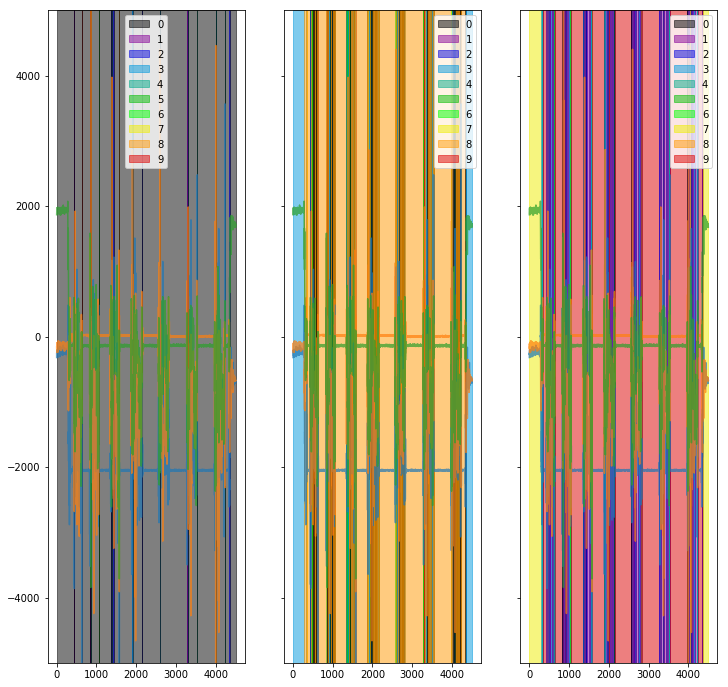

In [1]:
%matplotlib inline
# --------------------------------------------------
#
# Cluster the Data using Agglomerative Clustering
#
# --------------------------------------------------


import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph


N = 10
link_types = ('average', 'complete', 'ward')
event_labels = {i:i for i in range(N)}


FILE = 'data/pills-s0.npy'


def to_range(l, cmap):
    total = cmap.N
    idx = int((l[-1] / N) * total)
    return cmap(idx)

def boundaries(v):
    bounds = [0] + list(np.where(v[:-1] != v[1:])[0] + 1) + [len(v)-1]
    return [(bounds[i], bounds[i+1], v[bounds[i]]) for i in range(len(bounds)-1)]

def plot_bounds(ax, x, z):
    Zb = boundaries(z)
    ax.plot(x[:,:-3], alpha=.7)
    ax.set_ylim(-5000, 5000)
    # plot labels
    _cmap = plt.get_cmap('nipy_spectral')
    plots = {}
    for l in Zb:
        ev = event_labels[l[-1]]
        i = ax.axvspan(l[0], l[1], color=to_range(l, _cmap), alpha=0.5, label=ev)
        plots[ev] = i
    # legend
    legs = [plots[event_labels[i]] for i in sorted(event_labels)]
    nms = [event_labels[i] for i in sorted(event_labels)]
    ax.legend(legs, nms)


X = np.load(FILE)
idx = np.arange(X.shape[0])
model = AgglomerativeClustering(linkage=link_types[2], n_clusters=N)

# train
t0 = time.time()
model.fit(X)
elapsed_time = time.time() - t0
print('total time:', elapsed_time)

lbls = model.labels_
counts = np.unique(lbls, return_counts=True)
print('Labels:', model.labels_, counts)
bounds = boundaries(lbls)
print('boundaries', len(bounds))


fig, axes = plt.subplots(nrows=1, ncols=len(link_types), sharey='row', figsize=(12, 12))
print('axes', axes)


for i, tp in enumerate(link_types):
    ax = axes[i]
    model = AgglomerativeClustering(linkage=tp, n_clusters=N)
    # train
    t0 = time.time()
    model.fit(X)
    elapsed_time = time.time() - t0
    print(tp, elapsed_time)
    plot_bounds(ax, X, model.labels_)

plt.show()

axes (2, 3)
data average 0.4566032886505127 [4459   11   23    6    2    1    1    1    1    1]
   boundaries: 50
data complete 0.4467306137084961 [ 419    2   26  588    4    1   78   65 3317    6]
   boundaries: 478
data ward 0.5511748790740967 [ 134  950  212  344   57    2   78  421   48 2260]
   boundaries: 415


/users/grads/l/lthatch1/.local/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:1216: ComplexWarning: Casting complex values to real discards the imaginary part
  X = X.astype(np.double)


FFT average 0.4834864139556885 [4475    4   10    2    4    2    4    1    2    2]
   boundaries: 35
FFT complete 0.47406911849975586 [4087    6  350   10   42    2    2    1    4    2]
   boundaries: 645
FFT ward 0.5033724308013916 [ 486  104 2400  114   10 1383    2    1    2    4]
   boundaries: 2453


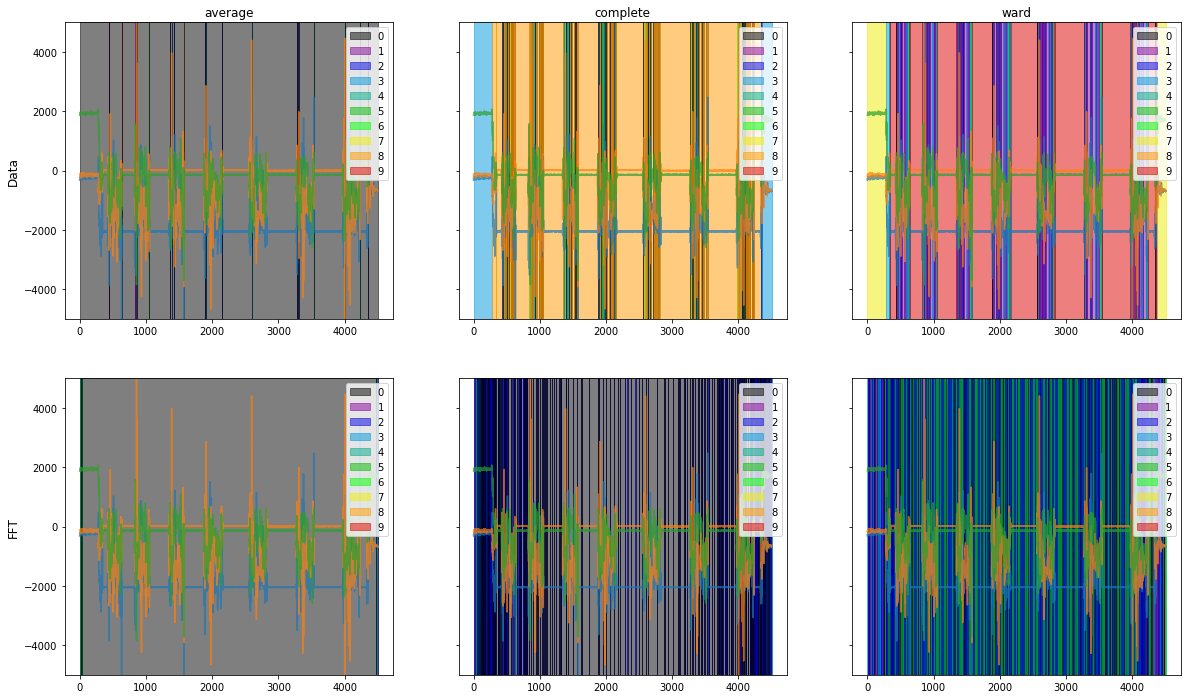

In [14]:
# %matplotlib tk
%matplotlib inline
# --------------------------------------------------
#
# Show both data clusters, and FFT clusters
#
# --------------------------------------------------

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize


N = 10
link_types = ('average', 'complete', 'ward')
event_labels = {i:i for i in range(N)}


FILE = 'data/pills-s0.npy'


def to_range(l, cmap):
    total = cmap.N
    idx = int((l[-1] / N) * total)
    return cmap(idx)

def boundaries(v):
    bounds = [0] + list(np.where(v[:-1] != v[1:])[0] + 1) + [len(v)-1]
    print('   boundaries:', len(bounds))
    return [(bounds[i], bounds[i+1], v[bounds[i]]) for i in range(len(bounds)-1)]

def plot_bounds(ax, x, z):
    Zb = boundaries(z)
    ax.plot(x[:,:-3], alpha=.7)
    ax.set_ylim(-5000, 5000)
    # plot labels
    _cmap = plt.get_cmap('nipy_spectral')
    plots = {}
    for l in Zb:
        ev = event_labels[l[-1]]
        i = ax.axvspan(l[0], l[1], color=to_range(l, _cmap), alpha=0.5, label=ev)
        plots[ev] = i
    # legend
    legs = [plots[event_labels[i]] for i in sorted(event_labels)]
    nms = [event_labels[i] for i in sorted(event_labels)]
    ax.legend(legs, nms)


X = np.load(FILE)
xf = np.fft.fft(X, axis=0)
idx = np.arange(X.shape[0])


fig, axes = plt.subplots(nrows=2, ncols=len(link_types), sharey='row', figsize=(20, 12))
print('axes', axes.shape)


# on raw data
for i, tp in enumerate(link_types):
    ax = axes[0][i]
    model = AgglomerativeClustering(linkage=tp, n_clusters=N)
    # train
    t0 = time.time()
    model.fit(X)
    elapsed_time = time.time() - t0
    _labels = model.labels_
    print('data', tp, elapsed_time, np.unique(_labels, return_counts=True)[1])
    plot_bounds(ax, X, _labels)
    
# on FFT data
for i, tp in enumerate(link_types):
    ax = axes[1][i]
    model = AgglomerativeClustering(linkage=tp, n_clusters=N)
    # train
    t0 = time.time()
    model.fit(xf)
    elapsed_time = time.time() - t0
    _labels = model.labels_
    print('FFT', tp, elapsed_time, np.unique(_labels, return_counts=True)[1])
    plot_bounds(ax, X, _labels)

# set col/row labels
cols = [l for l in link_types]
rows = ['Data', 'FFT']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, size='large')

plt.show()

axes (1, 3)
data average 0.459613561630249 [4459   23   11    6    2    1    1    1    1    1]
   boundaries: 50
data complete 0.4442460536956787 [3317  588  419   78   65   26    6    4    2    1]
   boundaries: 478
data ward 0.5540132522583008 [2260  950  421  344  212  134   78   57   48    2]
   boundaries: 415


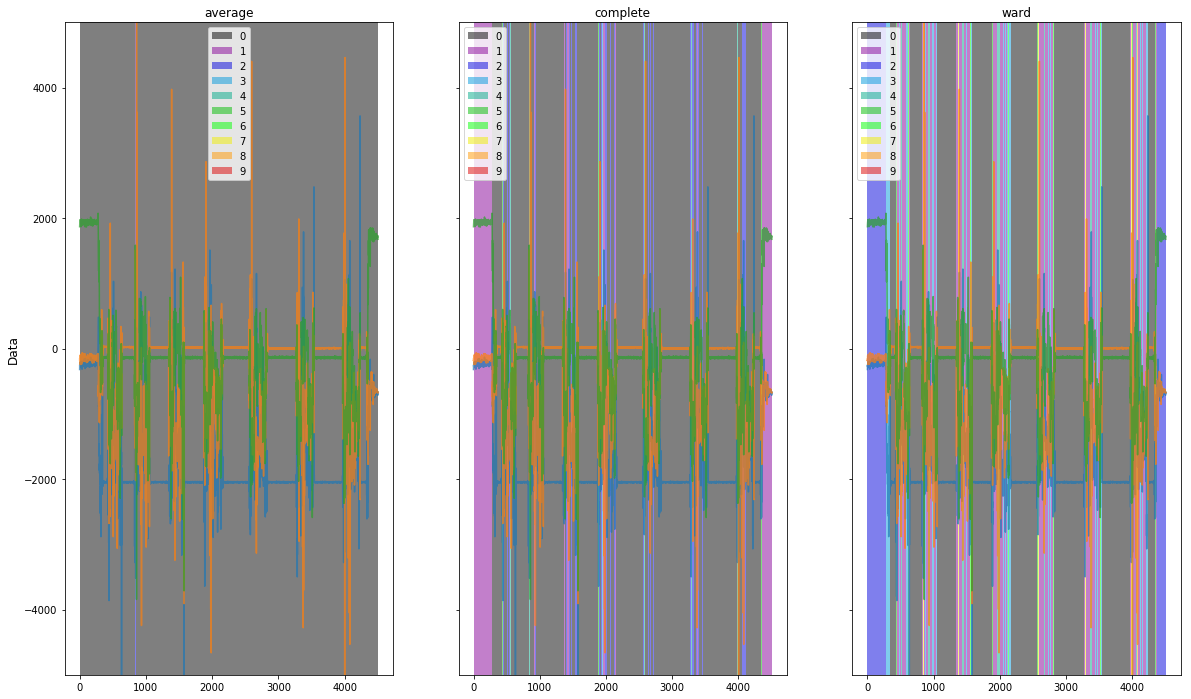

In [35]:
# %matplotlib tk
%matplotlib inline
# --------------------------------------------------
#
# sort clusters by size
#
# --------------------------------------------------

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize


N = 10
link_types = ('average', 'complete', 'ward')
event_labels = {i:i for i in range(N)}


FILE = 'data/pills-s0.npy'


def remap_labels(labels):
    map_keys = np.argsort(np.unique(labels, return_counts=True)[1]).reshape(N,1)[::-1]
    vals, idx = np.where(labels == map_keys)
    labels[idx] = vals
    return labels


def to_range(l, cmap):
    total = cmap.N
    idx = int((l[-1] / N) * total)
    return cmap(idx)

def boundaries(v):
    bounds = [0] + list(np.where(v[:-1] != v[1:])[0] + 1) + [len(v)-1]
    print('   boundaries:', len(bounds))
    return [(bounds[i], bounds[i+1], v[bounds[i]]) for i in range(len(bounds)-1)]

def plot_bounds(ax, x, z):
    Zb = boundaries(z)
    ax.plot(x[:,:-3], alpha=.7)
    ax.set_ylim(-5000, 5000)
    # plot labels
    _cmap = plt.get_cmap('nipy_spectral')
    plots = {}
    for l in Zb:
        ev = event_labels[l[-1]]
        i = ax.axvspan(l[0], l[1], color=to_range(l, _cmap), alpha=0.5, label=ev, linewidth=0)
        plots[ev] = i
    # legend
    legs = [plots[event_labels[i]] for i in sorted(event_labels)]
    nms = [event_labels[i] for i in sorted(event_labels)]
    ax.legend(legs, nms)


X = np.load(FILE)
xf = np.fft.fft(X, axis=0)
idx = np.arange(X.shape[0])


fig, axes = plt.subplots(nrows=1, ncols=len(link_types),  sharey='row', figsize=(20, 12), squeeze=False)
print('axes', axes.shape)


# on raw data
for i, tp in enumerate(link_types):
    ax = axes[0][i]
    model = AgglomerativeClustering(linkage=tp, n_clusters=N)
    # train
    t0 = time.time()
    model.fit(X)
    elapsed_time = time.time() - t0
    _labels = model.labels_
    _labels = remap_labels(_labels)
    print('data', tp, elapsed_time, np.unique(_labels, return_counts=True)[1])
    plot_bounds(ax, X, _labels)
    

# set col/row labels
cols = [l for l in link_types]
rows = ['Data']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, size='large')

plt.show()